# Journal Profiling Part 2: Impact Metrics

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract [publications data ](https://docs.dimensions.ai/dsl/datasource-publications.html) for a specific journal, as well its authors and affiliations.

This tutorial is the second of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.


In this notebook we are going to:

* Load the researchers data previously extracted
* Enrich it by building a dataset focusing on their impact in terms of no of papers, citations etc.. 
* Visualize the results with plotly to have a quick overview of the results 

In [12]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 24, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import os, sys, time, json
from tqdm.notebook import tqdm
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


In [2]:
#
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)
    
def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

## Measuring the Impact of Researchers within a Journal

Goal: from the list of authors and publications we previously extracted, we want to create a new dataset focused on **researchers** with the following information:
* Number of papers
* Citations median 
* Altmetric Attention Score median 
* Last publication year 

This data will allow to determine the 'impact' of a researcher within the journal.

### Load the publications and authors data previously saved

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
1. open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
2. grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the files called `1_publications.csv` and `1_publications_authors.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
3. move the files inside the `journal-profile-data` folder you just created


In [3]:
dfpubs = pd.read_csv(FOLDER_NAME+"/1_publications.csv")
authors = pd.read_csv(FOLDER_NAME+"/1_publications_authors.csv")

In [4]:
# replace empty values with 0 so to allow bulk calculations
dfpubs = dfpubs.fillna(0)
authors = authors.fillna(0)

### Isolate the Researchers data (= authors with an ID)

In [5]:
researchers = authors.query("researcher_id!=0")
print("Researchers total:",  len(researchers))
researchers.head(10)

Researchers total: 45040


,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,pub_id
264,"[{'city': 'Los Angeles', 'city_id': 5368361, '...",True,grid.19006.3e,Yi,Ding,['0000-0003-3595-2493'],"['Bioinformatics Interdepartmental Program, Un...",ur.010112262235.93,pub.1144028502
265,"[{'city': 'Los Angeles', 'city_id': 5368361, '...",True,grid.19006.3e,Kangcheng,Hou,['0000-0001-7110-5596'],"['Bioinformatics Interdepartmental Program, Un...",ur.016361002743.43,pub.1144028502
266,"[{'city': 'Los Angeles', 'city_id': 5368361, '...",0,grid.19006.3e,Kathryn S.,Burch,['0000-0001-9624-2108'],"['Bioinformatics Interdepartmental Program, Un...",ur.016425610250.34,pub.1144028502
267,"[{'city': 'Los Angeles', 'city_id': 5368361, '...",0,grid.19006.3e,Sandra,Lapinska,0,"['Bioinformatics Interdepartmental Program, Un...",ur.012302603635.50,pub.1144028502
268,"[{'city': 'Aarhus', 'city_id': 2624652, 'count...",0,grid.7048.b,Florian,Privé,0,['Department of Economics and Business Economi...,ur.013660120354.44,pub.1144028502
269,"[{'city': 'Aarhus', 'city_id': 2624652, 'count...",0,grid.7048.b,Bjarni,Vilhjálmsson,['0000-0003-2277-9249'],['Department of Economics and Business Economi...,ur.0603337465.80,pub.1144028502
270,"[{'city': 'Los Angeles', 'city_id': 5368361, '...",0,grid.19006.3e,Sriram,Sankararaman,0,"['Bioinformatics Interdepartmental Program, Un...",ur.0575736217.50,pub.1144028502
271,"[{'city': 'Los Angeles', 'city_id': 5368361, '...",True,grid.19006.3e,Bogdan,Pasaniuc,['0000-0002-0227-2056'],"['Bioinformatics Interdepartmental Program, Un...",ur.0737513674.23,pub.1144028502
272,"[{'city': 'Singapore', 'city_id': 1880252, 'co...",True,grid.414735.0,Emmanuelle,Szenker-Ravi,['0000-0003-4839-737X'],['Laboratory of Human Genetics and Therapeutic...,ur.016624747106.72,pub.1143833644
274,"[{'city': 'Singapore', 'city_id': 1880252, 'co...",0,grid.4280.e,Muznah,Khatoo,0,['Laboratory of Human Genetics and Therapeutic...,ur.0771147362.34,pub.1143833644


### Enrich the data with Impact Statistics

First, let's pivot on the researcher ID field to eliminate duplicates and count them 

In [6]:
researchers_impact = researchers[['researcher_id', 'pub_id']].groupby('researcher_id', as_index=False).count().sort_values(by=['pub_id'], ascending=False).reset_index(drop=True)
researchers_impact.rename(columns={"pub_id": "pubs"}, inplace=True)
researchers_impact.head(10)

,researcher_id,pubs
0,ur.0723426172.10,77
1,ur.01277776417.51,51
2,ur.0641525362.39,42
3,ur.011675454737.09,39
4,ur.01264737414.70,39
5,ur.012264440652.05,36
6,ur.01247426430.47,36
7,ur.01317433110.75,36
8,ur.0637651205.48,35
9,ur.01174076626.46,34


Second, for each researcher ID we can query all of his/her publications so to calculate the following metrics: 

* citations median 
* altmetric median 
* last publication year 

Also, we add a new field with the Dimensions URL of the researcher, as it can be handy later on to open up its profile page online.


In [7]:

def get_name_surname(researcher_id):
    """
    eg
    >>> get_name_surname("ur.0723426172.10")
    'Kari Stefansson'
    """
    q = "researcher_id=='%s'" % researcher_id
    x = researchers.query(q)['first_name'].value_counts().idxmax()
    y = researchers.query(q)['last_name'].value_counts().idxmax()
    return f"{x} {y}"


# def dimensions_url(researcher_id):
#     return f"https://app.dimensions.ai/discover/publication?and_facet_researcher={researcher_id}"

fullnames, citations, altmetric, last_year, urls = [], [], [], [], []

for i, row in tqdm(researchers_impact.iterrows(), total=researchers_impact.shape[0]):
    q = "researcher_id=='%s'" % row['researcher_id']
    pub_ids = list(researchers.query(q)['pub_id'])
    fullnames.append(get_name_surname(row['researcher_id']))
    citations.append(dfpubs[dfpubs['id'].isin(pub_ids)]['times_cited'].mean())
    altmetric.append(dfpubs[dfpubs['id'].isin(pub_ids)]['altmetric'].mean())
    last_year.append(dfpubs[dfpubs['id'].isin(pub_ids)]['year'].max())
    urls.append(dimensions_url(row['researcher_id']))

researchers_impact['full_name'] = fullnames
researchers_impact['citations_mean'] = citations
researchers_impact['altmetric_mean'] = altmetric
researchers_impact['last_pub_year'] = last_year
researchers_impact['url'] = urls
# finally..
print("Researchers total:",  len(researchers_impact))
researchers_impact.head(10)

  0%|          | 0/23346 [00:00<?, ?it/s]

Researchers total: 23346


,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url
0,ur.0723426172.10,77,Kari Stefansson,201.493506,248.818182,2021,None
1,ur.01277776417.51,51,Unnur Thorsteinsdottir,131.862745,201.666667,2021,None
2,ur.0641525362.39,42,Gonçalo R. Abecasis,223.714286,167.809524,2021,None
3,ur.011675454737.09,39,Cornelia M van Duijn,216.102564,303.179487,2021,None
4,ur.01264737414.70,39,Tõnu Esko,244.564103,339.923077,2021,None
5,ur.012264440652.05,36,Jerome I. Rotter,176.555556,175.638889,2021,None
6,ur.01247426430.47,36,Gudmar Thorleifsson,142.805556,164.694444,2021,None
7,ur.01317433110.75,36,Caroline Hayward,256.166667,311.166667,2021,None
8,ur.0637651205.48,35,Daniel F Gudbjartsson,124.057143,211.142857,2021,None
9,ur.01174076626.46,34,André G Uitterlinden,228.058824,274.558824,2021,None


Save the data

In [8]:
save(researchers_impact, "2_researchers_impact_metrics.csv")

## Couple of Dataviz

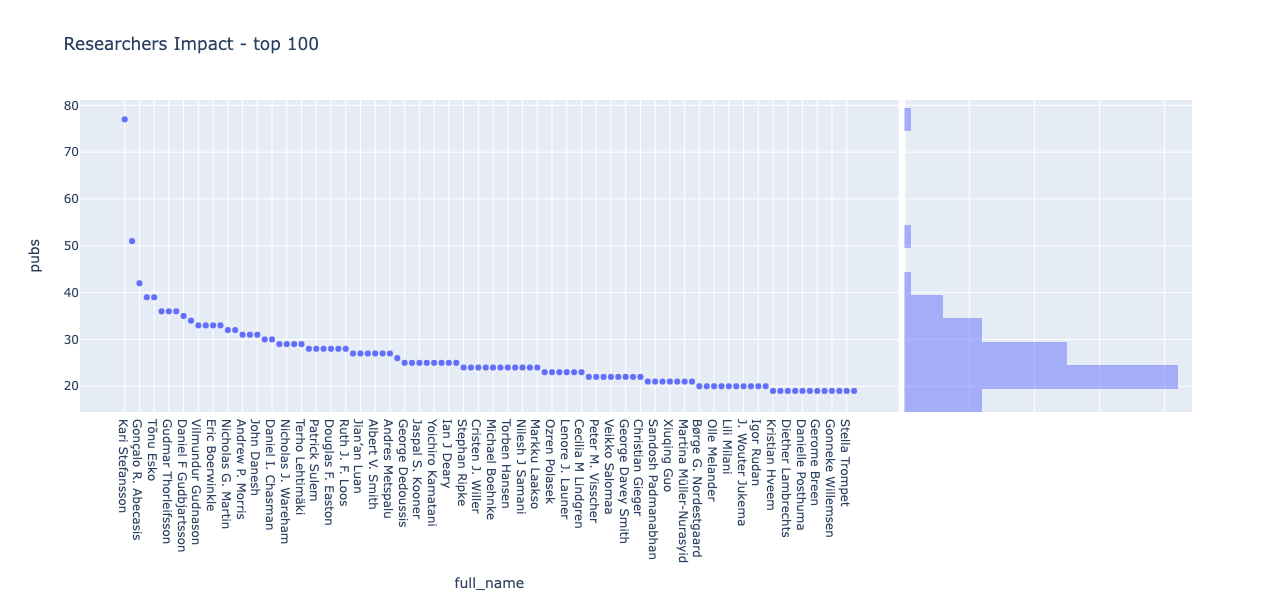

In [9]:
top100 = researchers_impact[:100]
px.scatter(top100, 
           x="full_name", y="pubs", 
           hover_name="full_name", 
           hover_data=['citations_mean', 'altmetric_mean'], 
           marginal_y="histogram", 
           height=600,
           title="Researchers Impact - top 100")

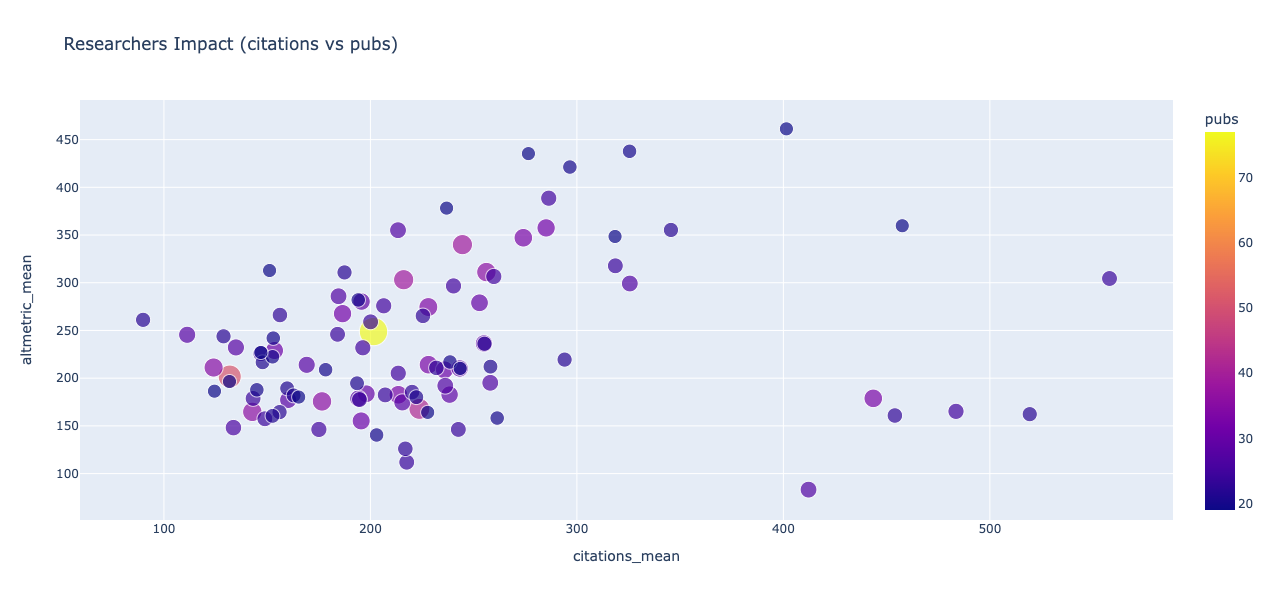

In [10]:
px.scatter(top100, 
           x="citations_mean", y="altmetric_mean", 
           hover_name="full_name", 
           hover_data=['pubs', 'citations_mean', 'altmetric_mean'], 
           color="pubs",
           size="pubs",
           height=600,
           title="Researchers Impact (citations vs pubs)")

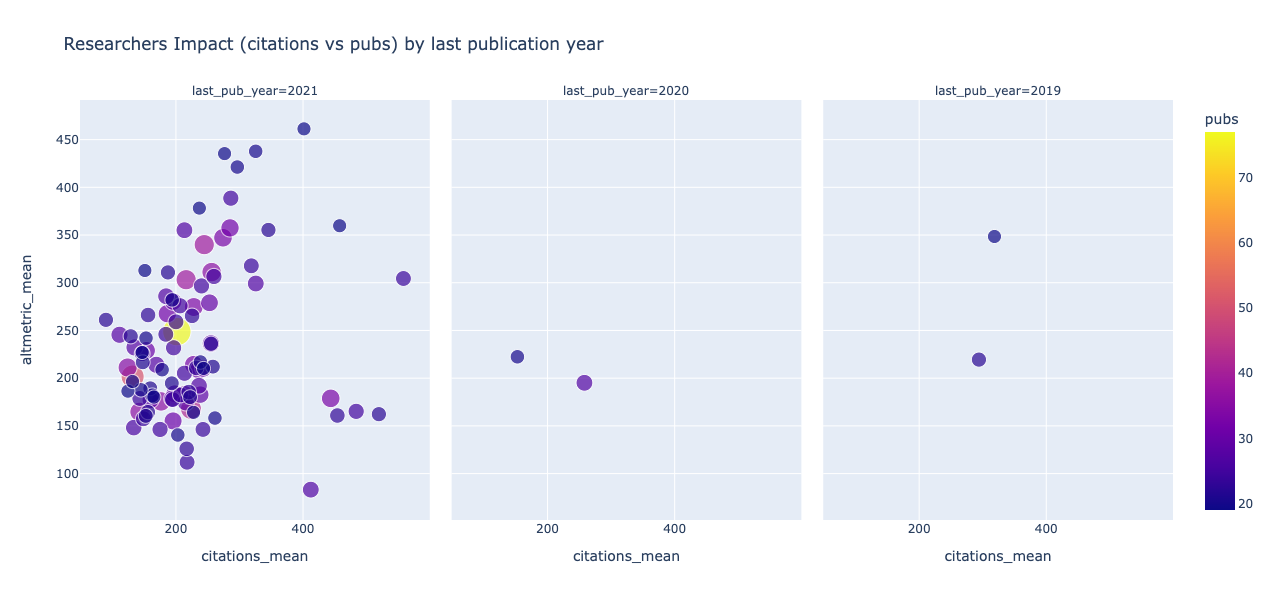

In [11]:
px.scatter(top100, 
           x="citations_mean", y="altmetric_mean", 
           hover_name="full_name", 
           hover_data=['pubs', 'citations_mean', 'altmetric_mean'], 
           color="pubs",
           size="pubs",
           facet_col="last_pub_year",
           height=600,
           title="Researchers Impact (citations vs pubs) by last publication year")